<a href="https://colab.research.google.com/github/LordLean/Decision-Tree-Classifier/blob/main/decision_tree_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [1]:
# This project uses the Wireless Indoor Localization Data Set
# from the UCI Machine Learning Repository. 
# https://archive.ics.uci.edu/ml/datasets/Wireless+Indoor+Localization


# Download and unzip resources.
!gdown --id "15K87a9qEACLFDtwBh0mYpiW9n9aqIziv"
!unzip "intro2ML-coursework1.zip"

from IPython.display import clear_output 
clear_output()

import numpy as np
import matplotlib.pyplot as plt

data_clean = np.loadtxt("./intro2ML-coursework1/wifi_db/clean_dataset.txt")
data_noisy = np.loadtxt("./intro2ML-coursework1/wifi_db/noisy_dataset.txt")

## Node Class

In [2]:
class Node:
    def __init__(self, attribute, value, left=0, right=0, leaf=True, label=0):
        """ A class representing a node.
        
        Args:
            attribute (int) : wifi signal 1-7
            value (float)   : split data by this value into left and right nodes
            left (int)      : integer representing a node
            right (int)     : integer representing a node
            leaf (boolean)  : True if a leaf node, False otherwise
        """
        self.attribute = attribute
        self.value = value
        self.left = left
        self.right = right
        self.leaf = leaf
        self.label = label

    def __repr__(self):
        if self.leaf == False:
            return 'Node("Wifi_{} < {}, {}, {}, {}, {}")'.format(self.attribute,
                                                             self.value,
                                                             self.left,
                                                             self.right,
                                                             self.leaf,
                                                             self.label)
        else:
            return 'Node("Leaf", Label: {})'.format(self.label)


if __name__ == '__main__':
    node = Node(attribute="1", value="-10.5", left=0, right=0, leaf=False, label=0)
    print(node)

Node("Wifi_1 < -10.5, 0, 0, False, 0")


## Decision Tree Class

In [3]:
class DecisionTreeClassifier:
  ''''
  Recursive function to compute maximum depth of decision tree. 
  Used for depth analysis and plotting decision tree visualization.

          Parameters:
                  nodes (dict): Dictionary of nodes -> {node no. : Node()}
                  node_no (int): Integer used to reference relevant Node obj. Defaults to root node (1).
          Returns:
                  Depth of tree (int).
  '''


  def __init__(self):
    self.nodes = {}



  def fit(self, Xy, X=0, y=0):
    '''
    Build a decision tree classifier from the training set (X, y). 
    '''
    _, _, self.nodes, _ = self.compute_node(data=Xy, node_number=1, nodes=self.nodes, max_node_number=1)
    self.depth = self.get_depth(self.nodes, 1)

  

  def predict(self, X_test):
    '''
    Predict classes for X_test.
    '''
    preds = []
    for record in range(X_test.shape[0]):
      test = X_test[record,:-1]
      label = self.label_from_test(test, self.nodes, 1)
      preds.append(label)
    return np.array(preds)



  def probabilities(self, data):
    probs = [np.count_nonzero(data == 1),
             np.count_nonzero(data == 2),
             np.count_nonzero(data == 3),
             np.count_nonzero(data == 4)]
    
    for prob in range(len(probs)):
        probs[prob] /= np.size(data)
        
    return probs



  def entropy(self, probs):
    h_dataset = 0
    for prob in probs:
      if prob != 0:
          h_dataset -= prob * np.log2(prob)
        
    return h_dataset


      
  def remainder(self, left, right):
    count_left = np.count_nonzero(left)
    count_right = np.count_nonzero(right)
    count_total = count_left + count_right
    
    remain = (count_left / count_total) * self.entropy(self.probabilities(left)) \
          + (count_right / count_total) * self.entropy(self.probabilities(right))
            
    return remain



  def find_split(self, data):
    # calculate total entropy
    h_entropy = self.entropy(self.probabilities(data[:, -1]))
    
    ### calculate information gain on first column ###
    max_info_gain = 0
    
    # sort array by each column in turn
    for col in range(data.shape[1] - 1):
      sorted_array = data[data[:,col].argsort()]

      for split in range(sorted_array.shape[0] - 1):
        # work out splitting value
        if sorted_array[split][col] != sorted_array[split + 1][col]:
          split_num = (sorted_array[split][col] + sorted_array[split + 1][col]) / 2

          remain = self.remainder(sorted_array[:split + 1, -1], sorted_array[split + 1:, -1])
          info_gain = h_entropy - remain
          if info_gain > max_info_gain:
            max_info_gain = info_gain
            max_info_gain_col = col
            max_info_gain_split = split_num
            left_branch = sorted_array[:split + 1]
            right_branch = sorted_array[split + 1:]
                
    if max_info_gain > 0:
        return max_info_gain_col, max_info_gain_split, left_branch, right_branch
    else:
        return 0, 0, [], []

  

  def determine_label(self, data):
    values, counts = np.unique(data[:,-1], return_counts=True)
    index = np.argmax(counts)
    return int(values[index])



  def compute_node(self, data, node_number, nodes, max_node_number):

    attribute, value, left_branch, right_branch = self.find_split(data)

    if len(left_branch) == 0 and len(right_branch) == 0:
      """Added label below"""
      node = Node(attribute=attribute, value=value, left=0, right=0, leaf=True, label=self.determine_label(data))
      nodes.update({node_number : node})         # update dictionary of nodes
    else:
      node_number_left = max_node_number + 1     # remember node number for left node
      node_number_right = max_node_number + 2    # remember node number for right node
      
      """Added label below"""
      node = Node(attribute=attribute, value=value, left=node_number_left, right=node_number_right,
                  leaf=False, label=self.determine_label(data))
      nodes.update({node_number : node})         # update dictionary of nodes

      max_node_number += 2                       # we've added two nodes so increment max node number by 2
      
      #go down left node
      node, node_number, nodes, max_node_number = self.compute_node(data=left_branch,
                                                                node_number=node_number_left,
                                                                nodes=nodes,
                                                                max_node_number=max_node_number)
      
      #go down right node
      node, node_number, nodes, max_node_number = self.compute_node(data=right_branch,
                                                                node_number=node_number_right,
                                                                nodes=nodes,
                                                                max_node_number=max_node_number)
        

    return node, node_number, nodes, max_node_number



  def label_from_test(self, test, nodes, node):
    if nodes[node].leaf == True:
      return nodes[node].label
    else:
      if test[nodes[node].attribute] < nodes[node].value:
        #go to left node
        return self.label_from_test(test, nodes, nodes[node].left)
      else:
        #go to right node
        return self.label_from_test(test, nodes, nodes[node].right)



  def error_rate(self, data, nodes):
    '''
    Return error rate for a set of labeled data vs. predictions
    stored within generated decision tree nodes.
    '''
    error_counter = 0
    for item in data:
      label = self.label_from_test(item, nodes, 1)
      if label != item[-1]:
        error_counter += 1
    return error_counter/len(data) 



  def __prune(self, nodes, data_validation):
    '''
    Parse the tree of nodes once and prune any leaf nodes in
    disagreement if action decreases validation error.
    '''
    for node_no, node in nodes.items():
      if not node.leaf:
        left_node = nodes[node.left]
        right_node = nodes[node.right]
        if left_node.leaf and right_node.leaf:
          # Calculate error rate on val. set with unpruned nodes.
          error_to_beat = self.error_rate(data_validation, nodes)
          # Iterate through both options for leaf node.
          for potential_leaf in [left_node, right_node]:
            nodes_copy = nodes.copy()
            # Replace parent node with potential leaf.
            nodes_copy[node_no] = potential_leaf
            # Calculate error rate on val. set with pruned (potential) nodes.
            curr_error = self.error_rate(data_validation, nodes_copy)
            if curr_error <= error_to_beat:
              error_to_beat = curr_error
              nodes = nodes_copy
              # Remove redundant nodes.
              nodes.pop(node.left,None)
              nodes.pop(node.right,None)

    return nodes



  def __prune_all(self, nodes, data_validation):
    '''
    Automate prune function to repeatedly parse the tree until
    pruning branches no longer decreases validation error.
    '''
    while len(nodes) != len(self.__prune(nodes, data_validation)):
      nodes = self.__prune(nodes, data_validation)

    return nodes



  def prune_tree(self, data_validation):
    '''
    Prune tree if resultant tree shows a positive effect on validation error.
    One must ensure validation data has not been included in training process.
    '''
    self.nodes = self.__prune_all(self.nodes, data_validation)


  
  def get_depth(self, nodes, node_no=1):
    ''''
    Recursive function to compute maximum depth of decision tree. 
    Used for depth analysis and plotting decision tree visualization.

            Parameters:
                    nodes (dict): Dictionary of nodes -> {node no. : Node()}
                    node_no (int): Integer used to reference relevant Node obj. Defaults to root node (1).
            Returns:
                    Depth of tree (int).
    ''' 
    if nodes[node_no].leaf:
      return 0
    else:
      l_depth = self.get_depth(nodes, nodes[node_no].left)
      r_depth = self.get_depth(nodes, nodes[node_no].right)
      if (l_depth > r_depth):
        return l_depth + 1
      else:
        return r_depth + 1



  def __get_node_text(self, node):
    if node.leaf:
      text = "leaf: Room {}".format(node.label)
    else:
      text = "x{} < {}".format(node.attribute, node.value)
    return text
    


  def __make_box(self, xy,text):
    x, y = xy
    plt.text(
        x, y,
        text,
        bbox=dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round,pad=1",
        ),
        ha="center", va="center"
    )



  def __draw_line(self, xy1, xy2, c="r"):
    x1, y1 = xy1
    x2, y2 = xy2
    plt.plot([x1,x2],[y1,y2], color=c)



  def __plot_nodes(self, node_no=1, x=1, y=1, depth=0, draw_connection=True):
    ''''
    Recursive function to plot decision tree tree.

            Parameters:
                    nodes (dict): Dictionary of nodes -> {node no. : Node()}
                    node_no (int): Integer used to reference relevant Node obj. Defaults to root node (1).
                    x (float): x coordinate for plot.
                    y (float): y coordinate for plot.
            Returns:
                    None
    ''' 
    if node_no == 1:
      depth = self.get_depth(self.nodes, node_no)

    node = self.nodes[node_no]
    self.__make_box((x,y), self.__get_node_text(node))
    depth /= 2

    
    if not node.leaf:
      left_x = x - depth
      right_x = x + depth
      new_y = y - 1
    
      if draw_connection:
        rgb="r"
        rgb = np.random.rand(3,)
        c = np.random.choice(["red","blue","green","black","orange"])
        self.__draw_line((x,y),(left_x,new_y), c)
        self.__draw_line((x,y),(right_x,new_y), c)
    
      self.__plot_nodes(node.left, left_x, new_y, depth, draw_connection)
      self.__plot_nodes(node.right, right_x, new_y, depth, draw_connection)



  def plot_tree(self):
    plt.rcParams.update({'font.size': 50})
    plt.figure(figsize=(120,100))
    self.__plot_nodes()
    plt.axis("off")
    plt.show()
          

## Demonstration

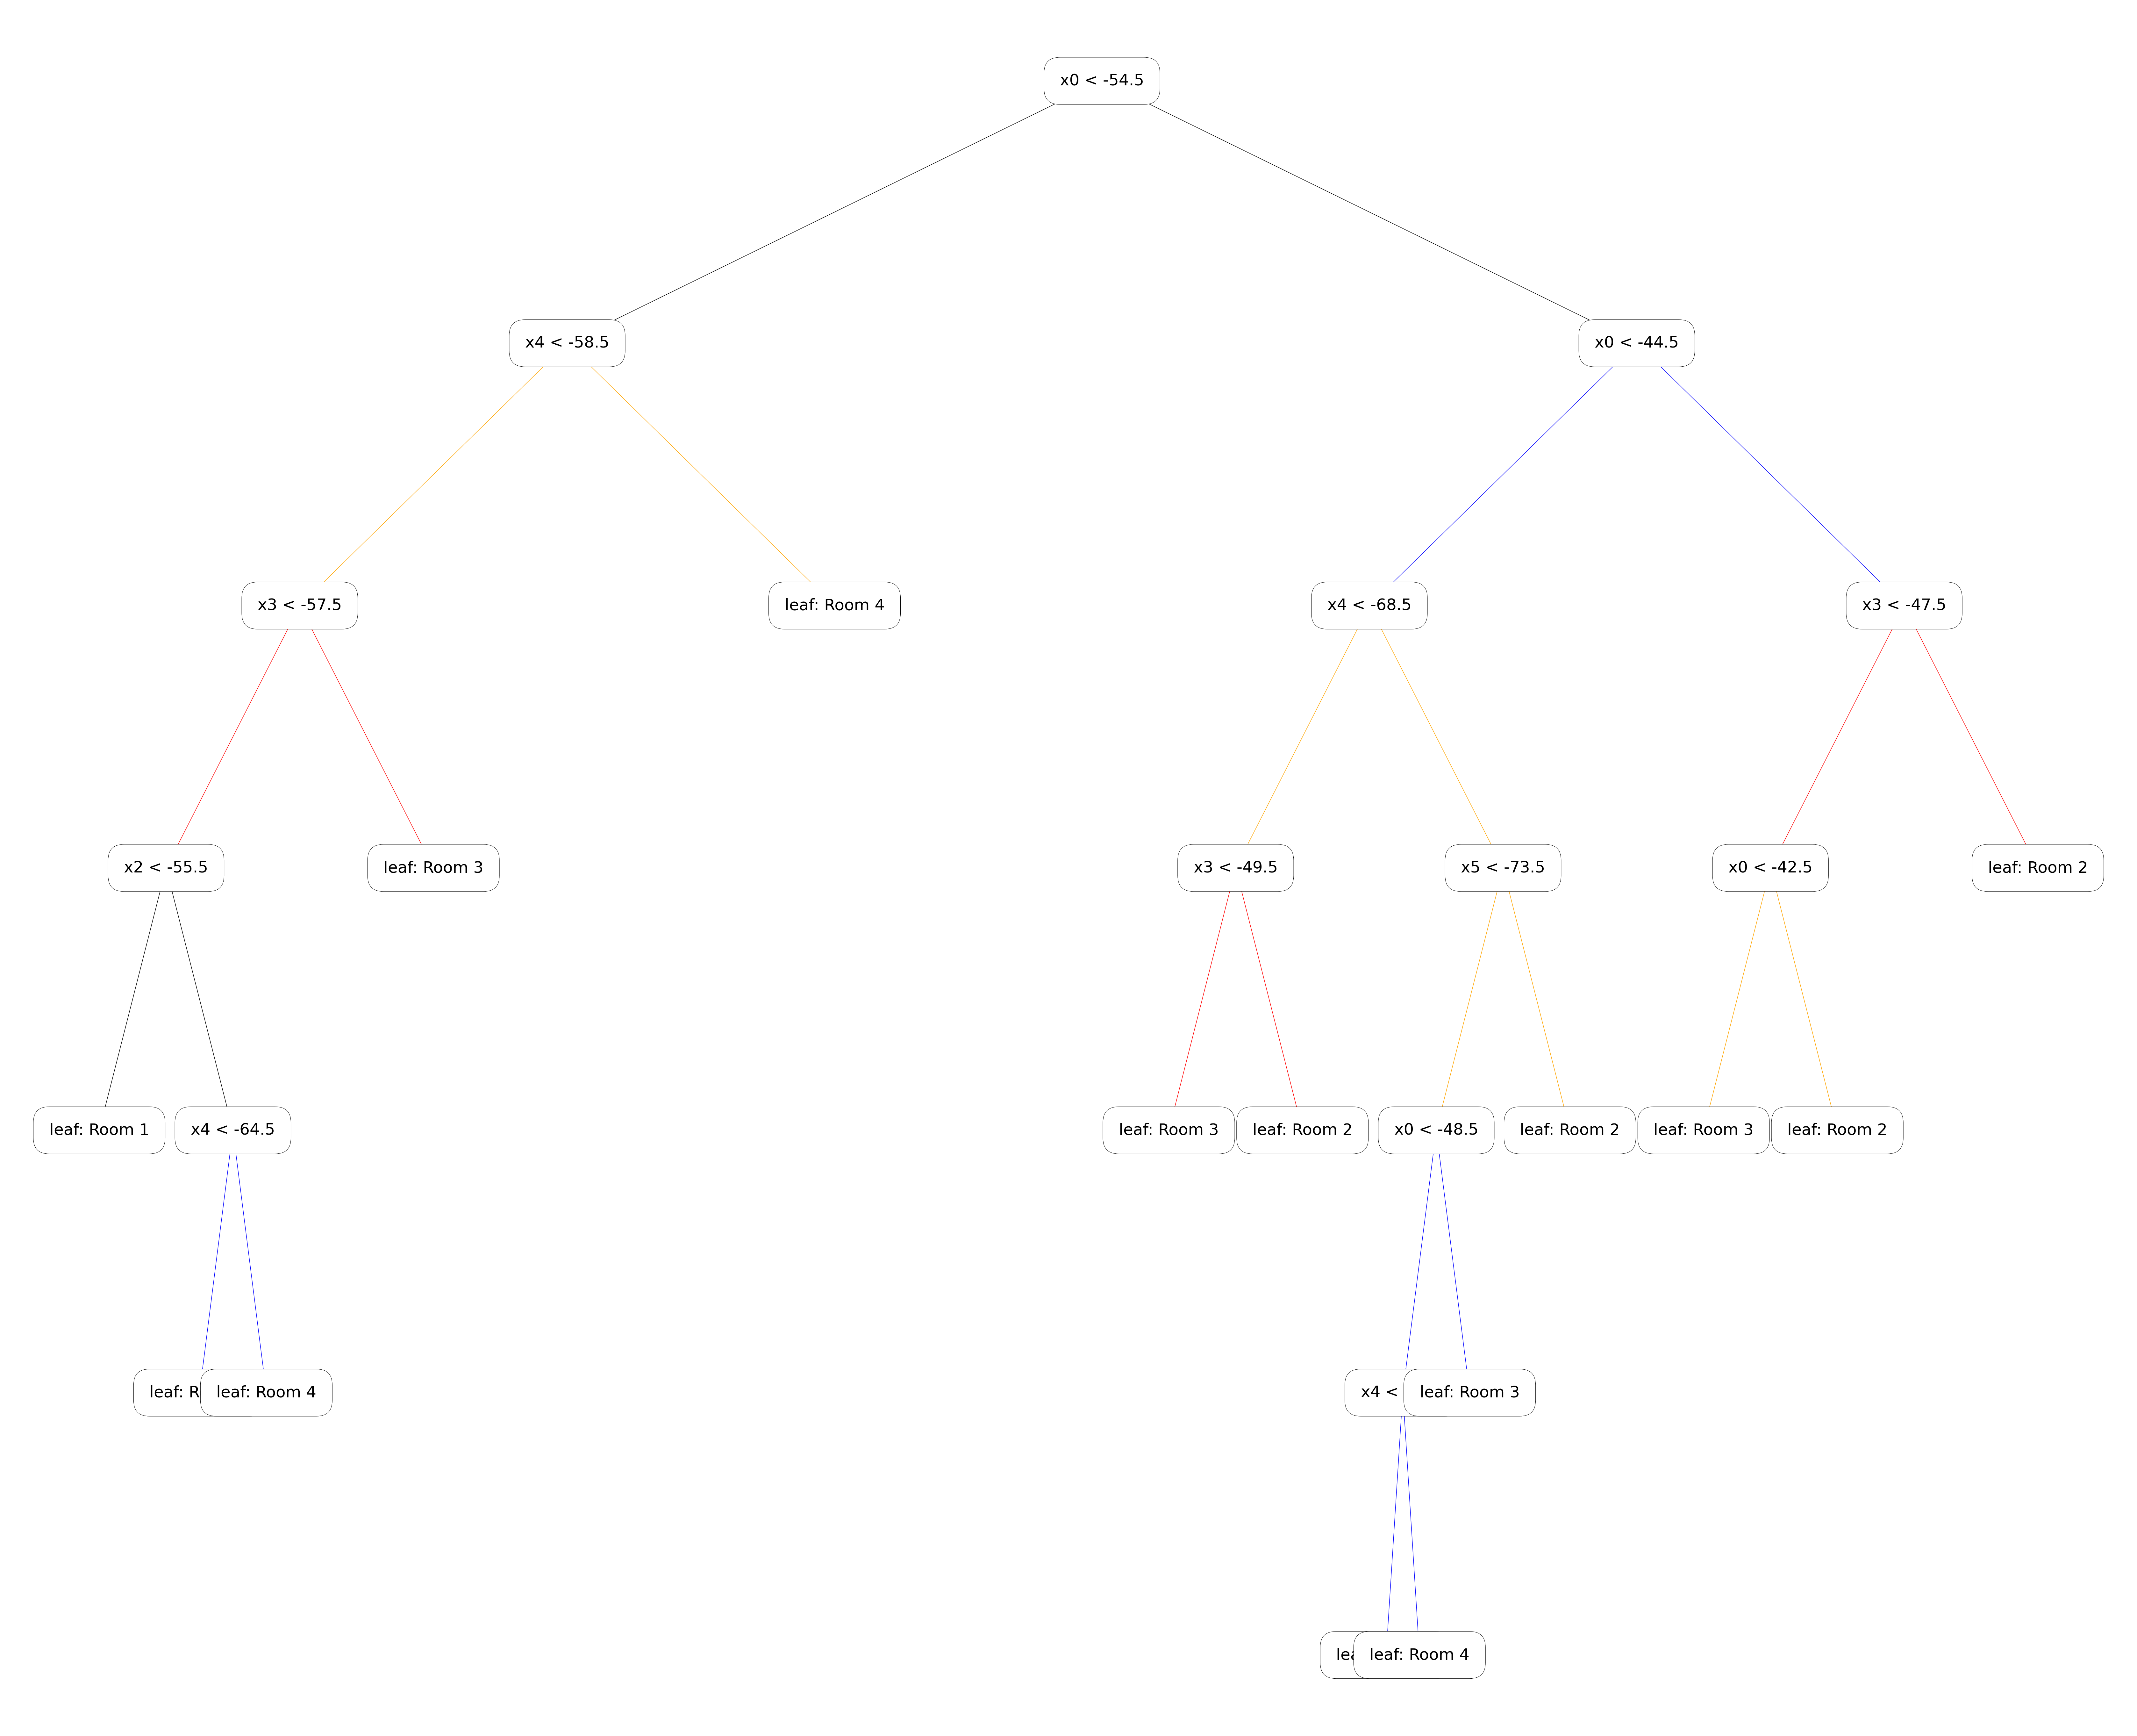

In [4]:
# Shuffle data
data = data_clean
np.random.shuffle(data)

# Split data into train (90%) and test (10%)
data_train = data[:int(data.shape[0]*0.9),:]
data_test = data[int(data.shape[0]*0.9):,:]

# Split training (100%) set further into train (80%) and validation (20%) sets.
data_validation = data_train[:int(data_train.shape[0]*0.2),:]
data_train = data_train[int(data_train.shape[0]*0.2):,:]

# Fit to training data
clf = DecisionTreeClassifier()
clf.fit(data_train)
clf.predict(data_train)
clf.prune_tree(data_validation)
clf.plot_tree()

In [ ]:
data = data_clean
data = data_noisy

d_list = []
for x in range(100):
  # Shuffle data
  np.random.shuffle(data)

  # Split data into train (90%) and test (10%)
  data_train = data[:int(data.shape[0]*0.9),:]
  data_test = data[int(data.shape[0]*0.9):,:]

  # Split training (100%) set further into train (80%) and validation (20%) sets.
  data_validation = data_train[:int(data_train.shape[0]*0.2),:]
  data_train = data_train[int(data_train.shape[0]*0.2):,:]

  # Fit to training data
  clf = DecisionTreeClassifier()
  clf.fit(data_train)
  clf.predict(data_train)
  clf.prune_tree(data_validation)
  d = clf.get_depth(clf.nodes)
  d_list.append(d)

In [ ]:
sum(d_list)/len(d_list)

7.36

In [ ]:
sum(d_list)/len(d_list)

9.84

## Evaluation Metrics

In [ ]:
def create_confusion_matrix(data, nodes):
  '''
  Create confusion matrix for classification of data according to decision tree nodes.
  '''
  # Set up empty confusion matrix
  conf_mat = np.zeros((4,4))
  #Run each example in test set through the decision tree
  for example in range(data.shape[0]):
      test = data[example,:]
      label = label_from_test(test, nodes, 1)
      conf_mat[int(test[-1])-1,label-1] += 1
  return conf_mat



def accuracy(conf_mat):
  '''
  Accuracy of model: correctly classified items/all items.
  '''
  correct = sum(np.diagonal(conf_mat))
  total = np.sum(conf_mat)
  # For calculating accuracy per class.
  acc_list = []
  for i, tp in enumerate(np.diagonal(conf_mat)):
    tp = tp
    fn = np.sum(conf_mat[i])- tp # the sum of values of corresponding rows except the TP value
    fp = np.sum(conf_mat[:,i]) - tp # the sum of values of corresponding column except the TP value.
    tn = total - tp - fn - fp # the sum of values of all columns and row except the values of that class that we are calculating the values for.
    class_acc = (tp + tn) / (tp + fn + fp + tn)
    acc_list.append(class_acc)
  return correct / total, acc_list



def precision(conf_mat): 
  '''
  Macro-Precision of model - how often a positively predicted result is correct.
  '''
  # Capture true positives on the diagonal and divide that value by the sum of the no. of predictions in that class.
  prec_list = [tp/sum(conf_mat[:,i]) for i, tp in enumerate(np.diagonal(conf_mat))]
  # Return average precision. 
  return sum(prec_list) / len(prec_list), prec_list



def recall(conf_mat):
  '''
  Macro-Recall of model - how often a positive result is correctly predicted.
  '''
  # Capture true positives on the diagonal and divide that value by the sum of the no. of actual instances in that class.
  rec_list = [tp/sum(conf_mat[i,:]) for i, tp in enumerate(np.diagonal(conf_mat))]
  # Return average recall. 
  return sum(rec_list) / len(rec_list), rec_list



def f1_score(conf_mat):
  '''
  Macro-f1 score - harmonic mean of precision and recall.
  '''
  p, _ = precision(conf_mat)
  r, _ = recall(conf_mat)
  return 2 * (p*r) / (p+r)



def micro_f1_score(conf_mat):
  '''
  Micro-f1 score - This analyzes all samples together by aggregating 
  contributions across all classes to compute the avg. metric. This is 
  preferable for multi-class classification if there is a class imbalance.
  '''
  tp = sum(np.diagonal(conf_mat))
  fp = 0
  # Sum all samples that are not on the diagonal (not a true positive result).
  for i, row in enumerate(conf_mat):
    fp += sum([item for item in row if row[i] != item])
  # Micro-precision = Micro-recall = Micro-f1.
  return tp/(tp+fp)



def evaluate(data, nodes): ##### Could swap acc with micro f1? Requires further thought.
  '''
  Generate macro-averages per class for the relevant metrics as well as 
  provide class-wise (per room) rates contained within each metric's dictionary. 
  '''
  # Create confusion matrix.
  conf_mat = create_confusion_matrix(data, nodes)

  # Compute averages and return relevant class-wise lists from confusion matrix.
  acc, acc_list = accuracy(conf_mat)
  p, prec_list = precision(conf_mat)
  r, rec_list = recall(conf_mat)
  f1 = f1_score(conf_mat)

  # Store accuracy score for each room.
  acc_dict = {"room_{}".format(i+1) : acc_list[i] for i, _ in enumerate(acc_list)}
  # Store avg. accuracy score.
  acc_dict["macro_avg"] = acc

  # Store precision score for each room.
  prec_dict = {"room_{}".format(i+1) : prec_list[i] for i, _ in enumerate(prec_list)}
  # Store macro-avg. precision score.
  prec_dict["macro_avg"] = p

  # Store recall score for each room.
  rec_dict = {"room_{}".format(i+1) : rec_list[i] for i, _ in enumerate(rec_list)}
  # Store macro-avg. recall score.
  rec_dict["macro_avg"] = r

  # Compute class-wise f1 scores.
  f1_dict = {}
  for i in range(conf_mat.shape[0]):
    room = "room_{}".format(i+1)
    p_room = prec_dict[room]
    r_room = rec_dict[room]
    f1_dict[room] = 2 * (p_room * r_room) / (p_room + r_room)
  # Store macro-avg. f1-score.
  f1_dict["macro_avg"] = f1

  return {"accuracy": acc_dict, "precision": prec_dict , "recall": rec_dict , "f1_score": f1_dict}



def get_depth(nodes, node_no=1):
  ''''
  Recursive function to compute maximum depth of decision tree. 
  Used for depth analysis and plotting decision tree visualization.

          Parameters:
                  nodes (dict): Dictionary of nodes -> {node no. : Node()}
                  node_no (int): Integer used to reference relevant Node obj. Defaults to root node (1).
          Returns:
                  Depth of tree (int).
  ''' 
  if nodes[node_no].leaf:
    return -1 # or 0?
  else:
    l_depth = get_depth(nodes, nodes[node_no].left)
    r_depth = get_depth(nodes, nodes[node_no].right)
    if (l_depth > r_depth):
      return l_depth + 1
    else:
      return r_depth + 1

In [ ]:
def label_from_test( test, nodes, node):
  if nodes[node].leaf == True:
    return nodes[node].label
  else:
    if test[nodes[node].attribute] < nodes[node].value:
      #go to left node
      return label_from_test(test, nodes, nodes[node].left)
    else:
      #go to right node
      return label_from_test(test, nodes, nodes[node].right)

evaluate(data_test, clf.nodes)

{'accuracy': {'macro_avg': 0.965,
  'room_1': 0.99,
  'room_2': 0.98,
  'room_3': 0.97,
  'room_4': 0.99},
 'f1_score': {'macro_avg': 0.9647689158807875,
  'room_1': 0.9807692307692307,
  'room_2': 0.9622641509433962,
  'room_3': 0.9361702127659575,
  'room_4': 0.9791666666666666},
 'precision': {'macro_avg': 0.9649453309692672,
  'room_1': 1.0,
  'room_2': 0.9444444444444444,
  'room_3': 0.9361702127659575,
  'room_4': 0.9791666666666666},
 'recall': {'macro_avg': 0.9645925652863128,
  'room_1': 0.9622641509433962,
  'room_2': 0.9807692307692307,
  'room_3': 0.9361702127659575,
  'room_4': 0.9791666666666666}}

In [ ]:
evaluated = evaluate(data_test, clf.nodes)

# Env. to print tables to latex.
import pandas as pd

def print_table(evaluated, tex=True):
  df = pd.DataFrame(evaluated).round(4).drop("accuracy", axis=1)
  if tex:
    print(df.to_latex())
  else:
    display(df)

print_table(evaluated,tex=False)

,precision,recall,f1_score
room_1,1.0000,0.9623,0.9808
room_2,0.9444,0.9808,0.9623
room_3,0.9362,0.9362,0.9362
room_4,0.9792,0.9792,0.9792
macro_avg,0.9649,0.9646,0.9648


## K-Folds Cross-Validation

In [ ]:
def k_folds(data, k=10, prune_check=False):
  '''
  Calculates evaluation metrics of the model on the one test fold witheld from the k-1 folds training set.

          Parameters:
                  data (numpy.ndarray): Matrix <shape: ( , 8)> containing WiFi signal strength data. 
                  k (int): Number of folds to split dataset into.
                  prune_check (bool): Boolean determiner for pruning the generated decision tree nodes or not.  
          Returns:
                  metrics (dict): list holding evaluation metrics, averaged across folds.
  ''' 
  # Shuffle data
  np.random.shuffle(data)

  # Create metrics dictionary to store calculations.
  metrics = {k : {} for k in ["precision", "recall", "f1_score"]}
  # Split data into k folds.
  folds = np.array_split(data, k)
  for i, fold in enumerate(folds):
    test = fold
    # Train is concatenation of k-1 folds.
    train = np.concatenate([data for j, data in enumerate(folds) if i!=j])
    
    # Create validation set from train - hardcoded 80-20 split. 
    validation = train[:int(train.shape[0]*0.2),:] # Validation is only used in the pruned case.
    train = train[int(train.shape[0]*0.2):,:]

    # Instance and fit classifier to training data.
    clf = DecisionTreeClassifier()
    clf.fit(train)
    # Prune tree if true.
    if prune_check:
      clf.prune_tree(validation)
    # Store generated decision tree nodes depending on whether the tree was pruned or not.
    nodes = clf.nodes

    # Create confusion matrix and evaluate for each of the test folds with model trained on k-1 folds.
    evaluated = evaluate(test, nodes)
    # Accuracy.
    metrics["accuracy"] = metrics.get("accuracy",0) + evaluated["accuracy"]
    # Calculate k folds metrics for each class -> keys are either class no. or macro-averages.
    for key, new_val in evaluated["precision"].items():
      metrics["precision"][key] = metrics.get("precision").get(key,0) + new_val
    for key, new_val in evaluated["recall"].items():
      metrics["recall"][key] = metrics.get("recall").get(key,0) + new_val
    for key, new_val in evaluated["f1_score"].items():
      metrics["f1_score"][key] = metrics.get("f1_score").get(key,0) + new_val
    # Max Depth of tree.
    metrics["depth"] = metrics.get("depth",0) + get_depth(nodes)

  # Average (k) metric calculation.
  for key, value in metrics.items():
    if isinstance(value, dict):
      for k2, v2 in value.items():
        metrics[key][k2] = v2/k
    else:
      # If accuracy/max depth metric then take avg.
      metrics[key] = value/k

  return metrics

In [ ]:
k_folds(data_clean)

{'accuracy': 0.9705,
 'depth': 10.6,
 'f1_score': {'macro_avg': 0.9703990804669866,
  'room_1': 0.9836435088564347,
  'room_2': 0.9623956513672673,
  'room_3': 0.9520102574162597,
  'room_4': 0.9827767021003837},
 'precision': {'macro_avg': 0.9706876774298688,
  'room_1': 0.986683516867479,
  'room_2': 0.9593190585199725,
  'room_3': 0.9549974836668993,
  'room_4': 0.9817506506651243},
 'recall': {'macro_avg': 0.9701121387883578,
  'room_1': 0.9811707770866134,
  'room_2': 0.9656925721495219,
  'room_3': 0.9494026999950661,
  'room_4': 0.9841825059222298}}

In [ ]:
%timeit k_folds(data_clean)

1 loop, best of 5: 2.32 s per loop


In [ ]:
k_folds(data_clean,prune_check=True)

{'accuracy': 0.959,
 'depth': 5.5,
 'f1_score': {'macro_avg': 0.9600077299959674,
  'room_1': 0.9832029279149725,
  'room_2': 0.9427419470680919,
  'room_3': 0.9231657813825294,
  'room_4': 0.9877489981445189},
 'precision': {'macro_avg': 0.9610592945271321,
  'room_1': 0.9754103768146211,
  'room_2': 0.9664939943710598,
  'room_3': 0.9042935912365726,
  'room_4': 0.9980392156862745},
 'recall': {'macro_avg': 0.9589631024386277,
  'room_1': 0.9916786226685798,
  'room_2': 0.9218979682529811,
  'room_3': 0.944477031694514,
  'room_4': 0.9777987871384358}}